# 门控循环单元GRU

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 初始化模型参数

In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    #输入到隐藏，隐藏到隐藏，偏移量
    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    #Z门
    W_xz, W_hz, b_z = three()
    #R门
    W_xr, W_hr, b_r = three()
    #真正算候选隐藏状态
    W_xh, W_hh, b_h = three()
    #输出
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    #一个隐藏层就有11个要学习的参数
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 定义初始化隐藏状态

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

## 定义门控循环单元模型

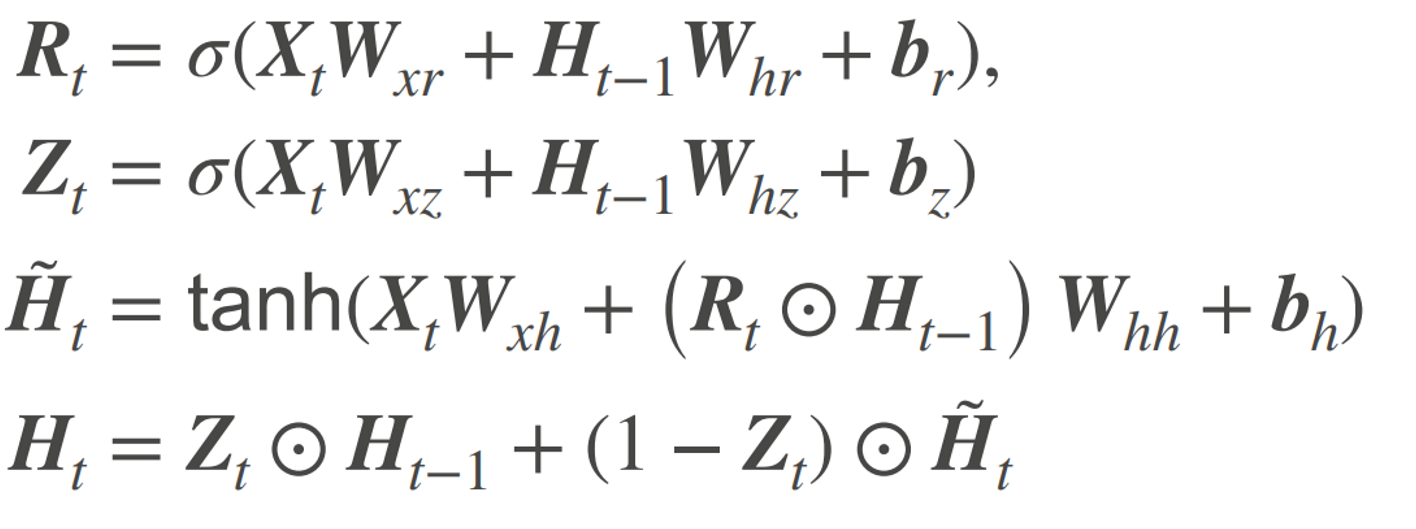

In [4]:
#按照公式写出来
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    #（num_steps,batch_size,vocab_size)
    #@这个符号是矩阵乘法 torch.mm torch.mul都是一样的
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

## 训练 

perplexity 1.0, 41475.2 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


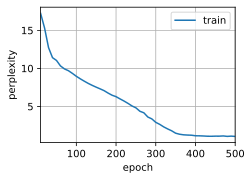

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 简洁实现

perplexity 1.0, 253223.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


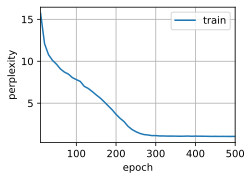

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 答疑

- R和Z的结构一样，怎么知道到底谁是遗忘门谁是重置门，这个我们需要把结果可视化一下才知道。R和Z的结构是我们期望模型是这样的，但是模型有可能不这样。
- GRU和LSTM数值稳定性比RNN要高，虽然参数多了，但是不一定会导致梯度爆炸
- GRU和RNN的grad clipping 一般都等于1 5 10,这三个比较常见
- R的作用是看多少Ht-1的信息，尽量多看Xt；Z的作用是有多少的概率绕过Ht-1，更新Ht
- GRU的初始化隐藏层和MLP的大小定义没有什么特别区别，一样
- 